Ce notebook analyse un fichier csv issu d'une attack pour en extraire l'information

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import csv
from scipy.optimize import minimize

In [7]:
def load_data_from_csv(filename):
    
    x = []
    y = []

    with open(filename, mode='r') as file:
        reader = csv.reader(file)
        next(reader)  # Sauter l'en-tête
        
        for row in reader:
            x.append(float(row[0]))  # Ajouter le temps
            y.append([float(val) for val in row[1:]])  # Ajouter les valeurs des luminosités
            
    x = np.array(x)
    y = np.array(y)
    
    print(f'Données chargées depuis le fichier {filename}')
    return x, y

In [8]:
name = "final_005"
filename = f"../../records/luminosity_signal/{name}.csv"
t, signal = load_data_from_csv(filename)
fps = 50
freq_message = 0.4
message = "0100100001001001"
len_msg = len(message)
array_brightness = signal

Données chargées depuis le fichier ../../records/luminosity_signal/final_005.csv


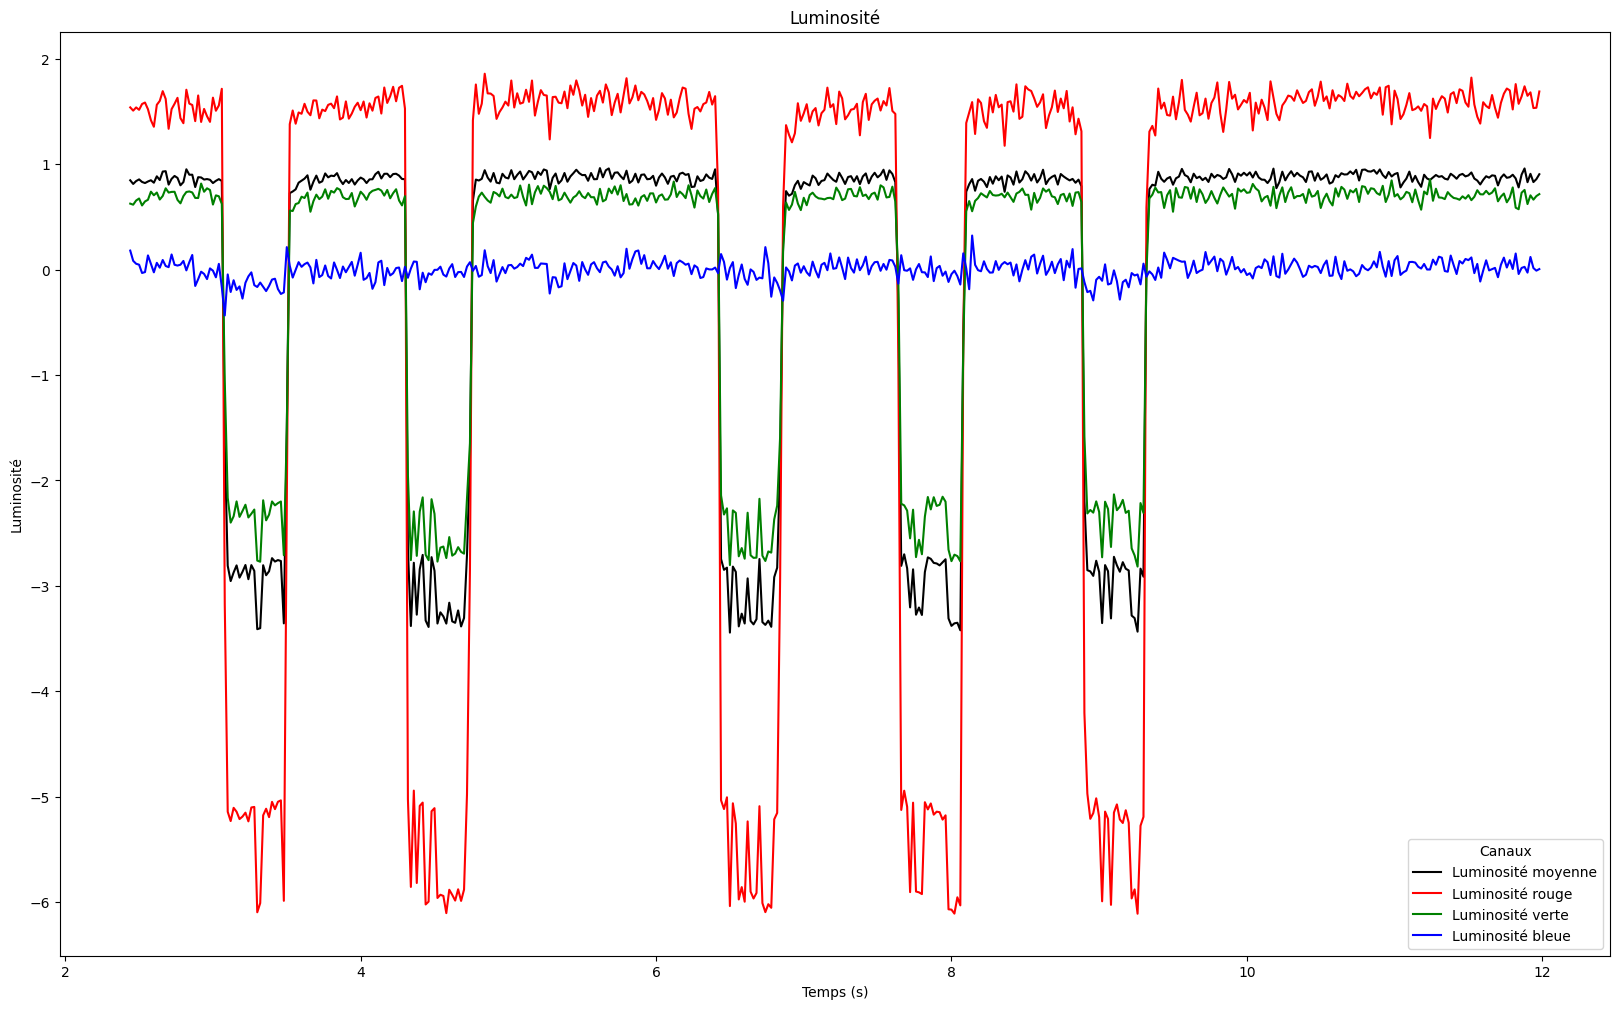

In [9]:
# Créer une figure et des axes
plt.figure(figsize=(20, 12))

# Tracer les courbes
plt.plot(t, array_brightness[:, 0], label='Luminosité moyenne', color='black')
plt.plot(t, array_brightness[:, 1], label='Luminosité rouge', color='red')
plt.plot(t, array_brightness[:, 2], label='Luminosité verte', color='green')
plt.plot(t, array_brightness[:, 3], label='Luminosité bleue', color='blue')

# Ajouter le titre et les labels
plt.title("Luminosité")
plt.xlabel("Temps (s)")
plt.ylabel("Luminosité")

# Ajouter la légende
plt.legend(title="Canaux")

# Sauvegarder le graphique en PDF
plt.savefig(f"{name}_plot.pdf")

# Afficher le graphique
plt.show()

In [10]:
x_red = array_brightness[:, 1]
lower_boud_mean = np.mean(x_red[np.where(x_red < 0)])
x_red -= lower_boud_mean
x_red = x_red / (np.max(x_red))
x_red -= 1.0
x_red = - x_red
x_blue = array_brightness[:, 3]
lower_boud_mean = np.mean(x_blue[np.where(x_blue < 0)])
x_blue -= lower_boud_mean
x_blue = x_blue / (np.max(x_blue))
x_blue -= 1.0
x_blue = - x_blue

x_green = array_brightness[:, 2]
lower_boud_mean = np.mean(x_green[np.where(x_green < 0)])
x_green -= lower_boud_mean
x_green = x_green / (np.max(x_green))
x_green -= 1.0
x_green = - x_green

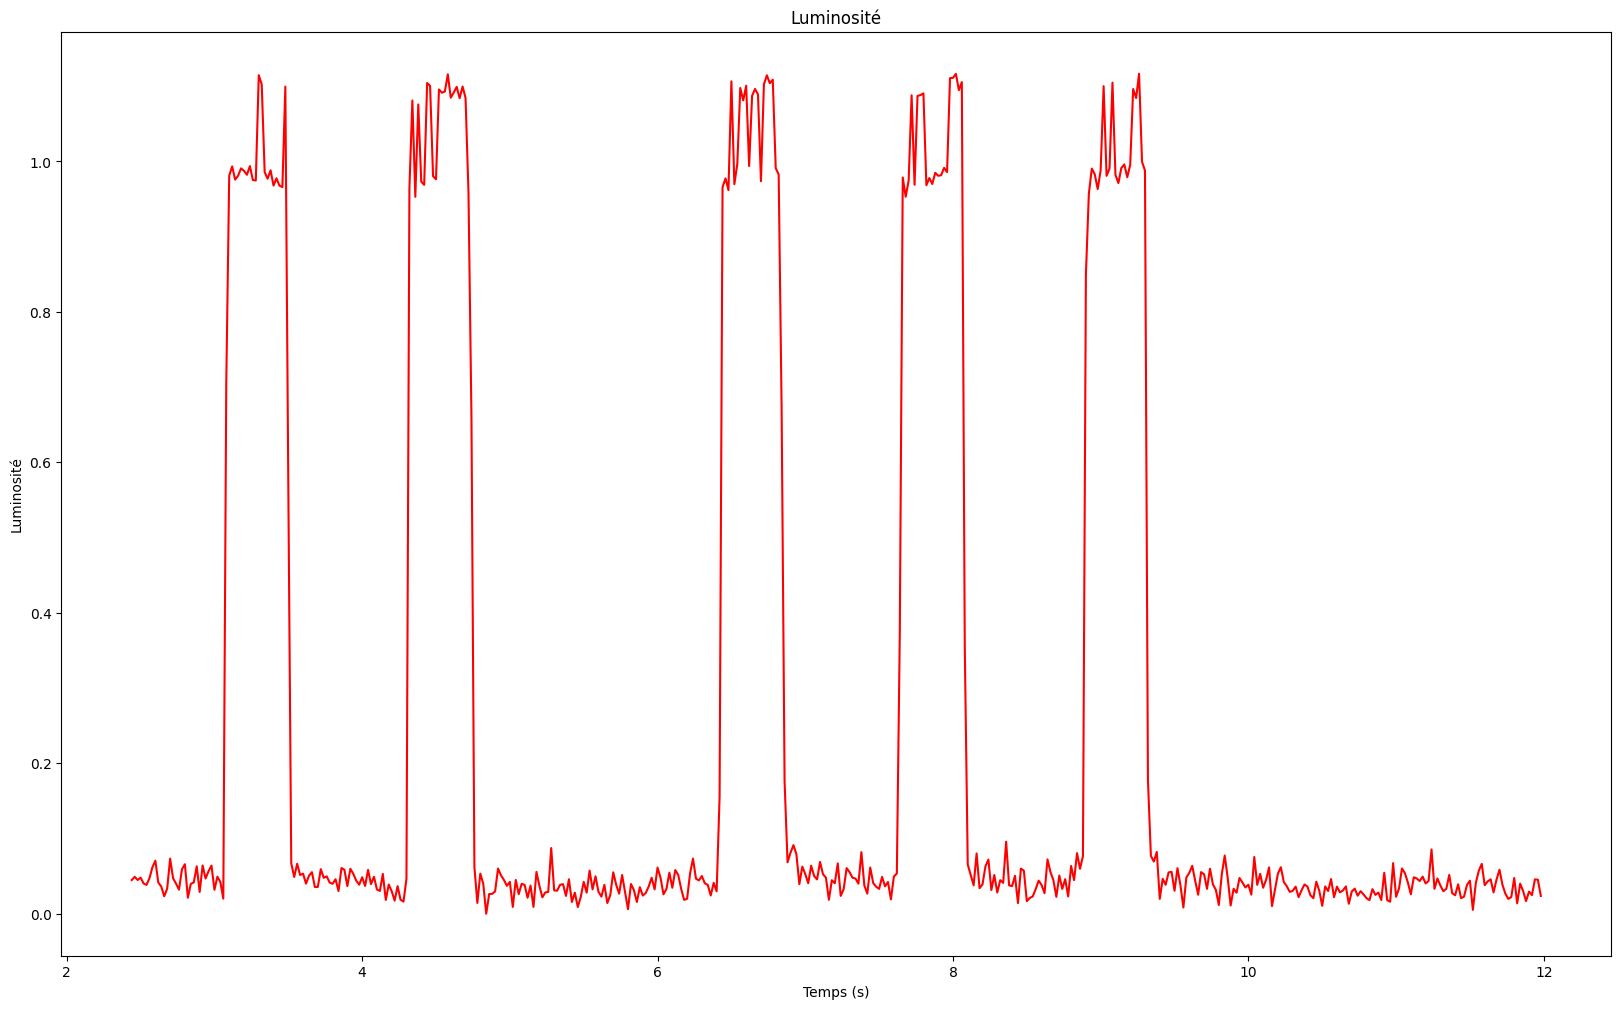

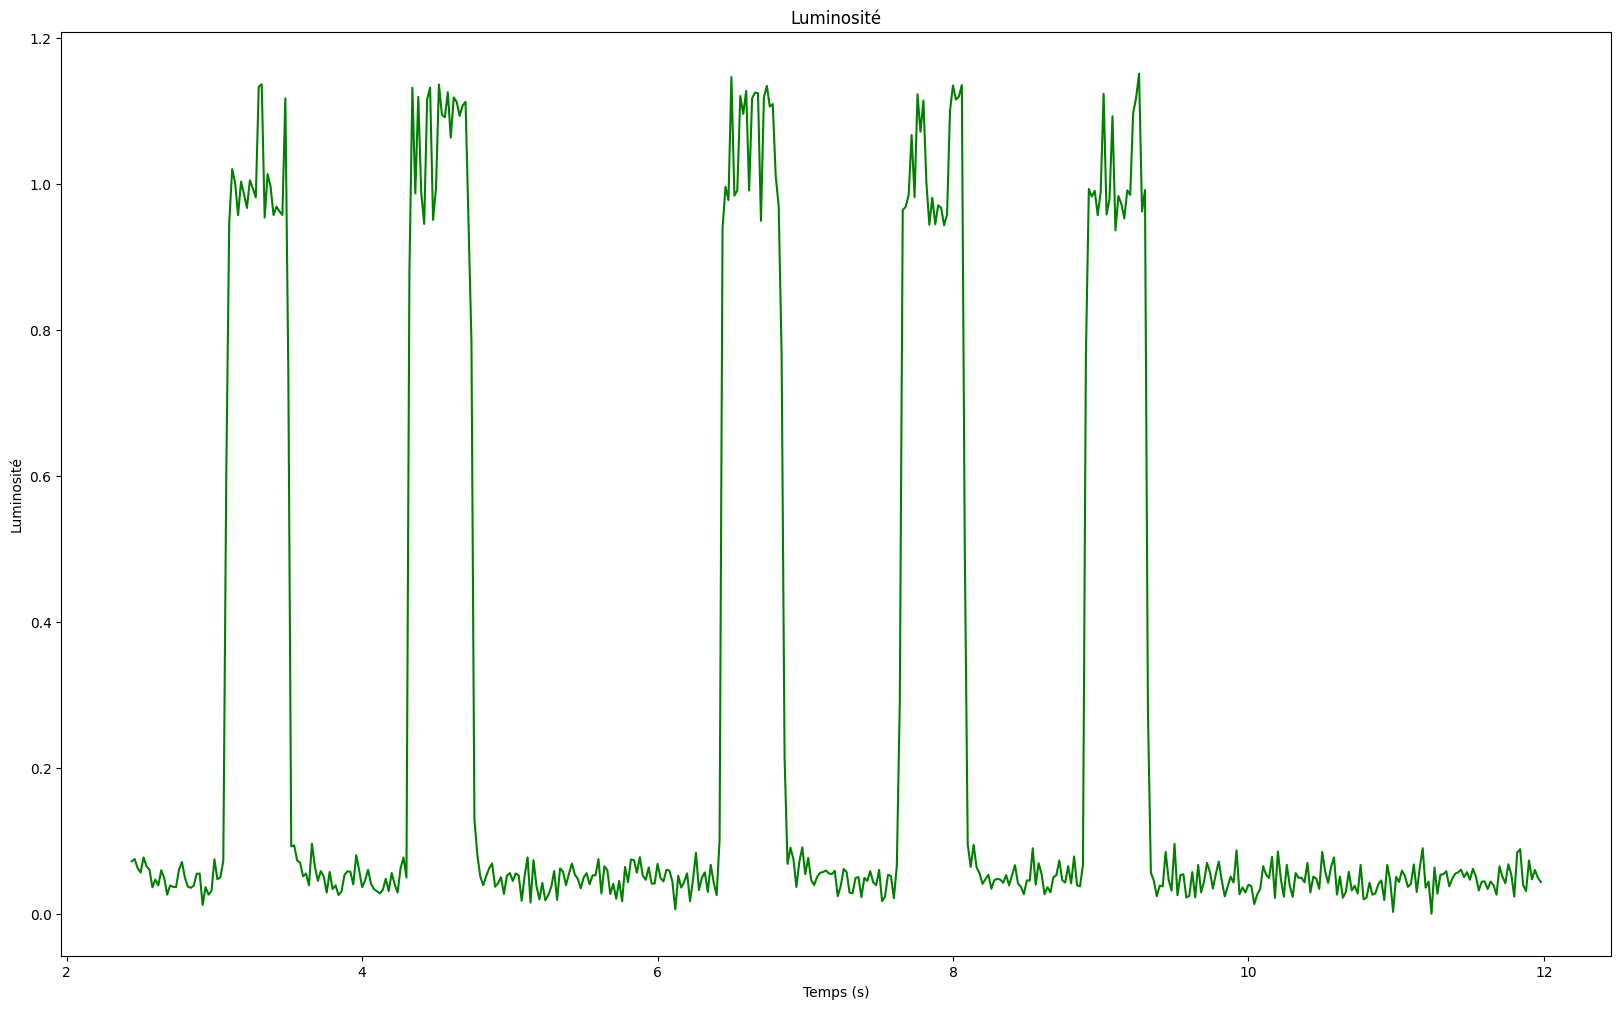

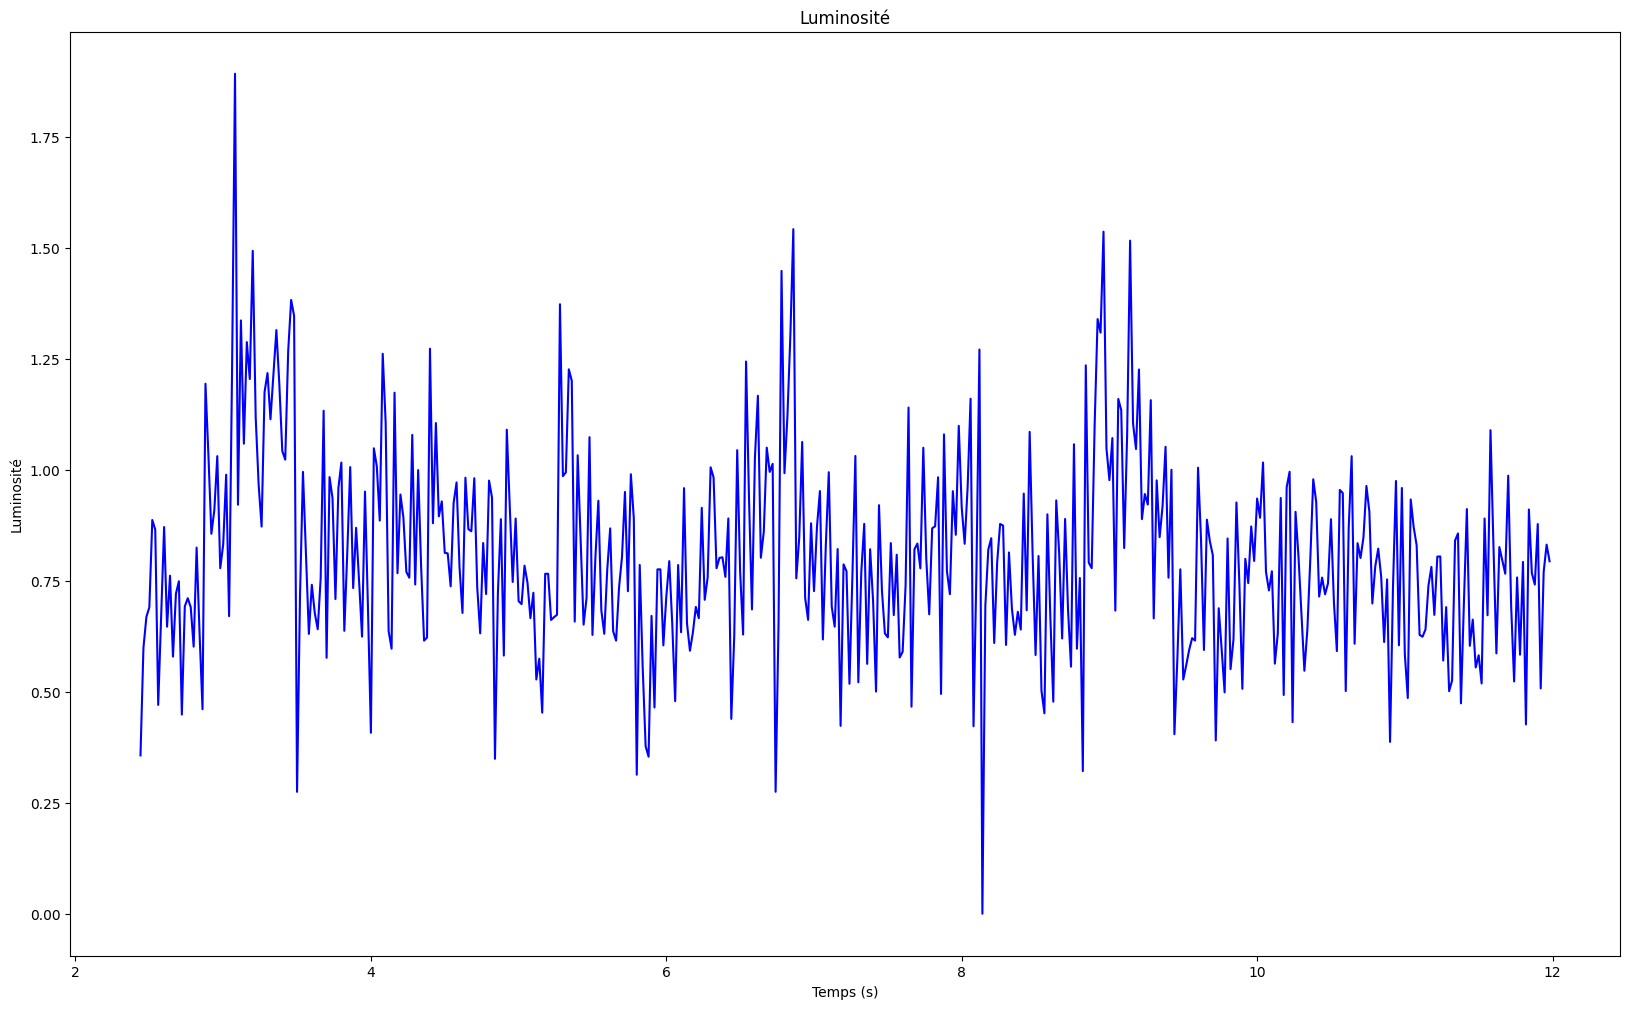

In [11]:
# Créer une figure et des axes
plt.figure(figsize=(20, 12))

# Tracer les courbes
plt.plot(t, x_red, label='Luminosité rouge', color='red')
plt.title("Luminosité")
plt.xlabel("Temps (s)")
plt.ylabel("Luminosité")
plt.savefig(f"{name}_plot_filtered.pdf")
plt.show()

plt.figure(figsize=(20, 12))
plt.plot(t, x_green, label='Luminosité verte', color='green')
plt.title("Luminosité")
plt.xlabel("Temps (s)")
plt.ylabel("Luminosité")

plt.show()

plt.figure(figsize=(20, 12))
plt.plot(t, x_blue, label='Luminosité bleue', color='blue')
plt.title("Luminosité")
plt.xlabel("Temps (s)")
plt.ylabel("Luminosité")

# Ajouter le titre et les labels
plt.title("Luminosité")
plt.xlabel("Temps (s)")
plt.ylabel("Luminosité")

# Afficher le graphique
plt.show()


In [12]:
def generate_crenaux(a, T, N1, len_msg):
    a = np.array(a)
    T = np.array(T)
    N2 = np.sum(T*fps) + N1
    N2 = int(N2)
    
    # Longueur totale calculée à partir de N2

    crenaux = np.zeros(len_msg)  # Fonction initialisée à zéro
    
    # Génération des créneaux entre N1 et N2
    for i, coeff in enumerate(a):
        if i ==0:
            start = N1

        else:
            start += int(T[i-1]*fps)  # Début du créneau

        end = start + int(T[i]*fps) 
        
        if start >= N2:     # Si le créneau commence après N2, sortir
            break
        # Mettre les valeurs dans le tableau

        crenaux[start:min(end, N2)] = coeff

    return crenaux

In [13]:
signal_transfo_crenaux = x_green.copy()
threeshold = 0.5
signal_transfo_crenaux[signal_transfo_crenaux > threeshold] = 1.0
signal_transfo_crenaux[signal_transfo_crenaux<= threeshold] = 0.0

In [14]:
len_msg = 24
T_min = freq_message*0.9
T_max = freq_message*1.2
N1_min = 0
N1_max = int(fps*freq_message) + 1
N1_init = int(0.05*fps)
def erreur_quadratique(params, t, X):
    
    crenaux_theorique = generate_crenaux(params[len_msg+1:], params[:len_msg], int(params[len_msg]), len(t))
    MSE = np.mean((X-crenaux_theorique)**2)
    
    return MSE

# Paramètres initiaux (alpha, T, a)
params_init = [freq_message]*len_msg + [N1_init] + [*np.random.choice([0, 1], size=len_msg)]
bounds = [(T_min, T_max)] * len_msg + [(N1_min, N1_max)] + [(0, 1)] * len_msg

result = minimize(erreur_quadratique, params_init, args=(t, signal_transfo_crenaux), bounds=bounds, method='Powell')

In [15]:
# Résultats de l'optimisation
params_opt = result.x
T_opt = params_opt[:len_msg]
a_opt = np.round(params_opt[len_msg+1:]).astype(int)  # Convertir a en entier (0 ou 1)
N1_opt = params_opt[len_msg]

# Affichage des résultats
print(f"Paramètres optimisés : T = {T_opt}, N1 = {N1_opt}, a = {a_opt}")
message_decoded = ''.join(map(str, a_opt))
print(f"Message_deco : {message_decoded}")
print(f"Message_true : {message}")


message_array = [int(bit) for bit in message]

# Générer le signal approximé avec les paramètres optimisés
X_approx = generate_crenaux(a_opt, T_opt, int(N1_opt), len(t))
X_detection = signal_transfo_crenaux

Paramètres optimisés : T = [0.38838029 0.37746992 0.37085823 0.38836595 0.37085823 0.37085823
 0.37085823 0.37085823 0.37085823 0.37085823 0.37085823 0.42647369
 0.38838574 0.4058935  0.44838574 0.44838574 0.37085823 0.42881146
 0.37085823 0.37085823 0.37085823 0.37085823 0.37085823 0.37085823], N1 = 1.5695678677344806, a = [0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0]
Message_deco : 001001000001001001000000
Message_true : 0100100001001001


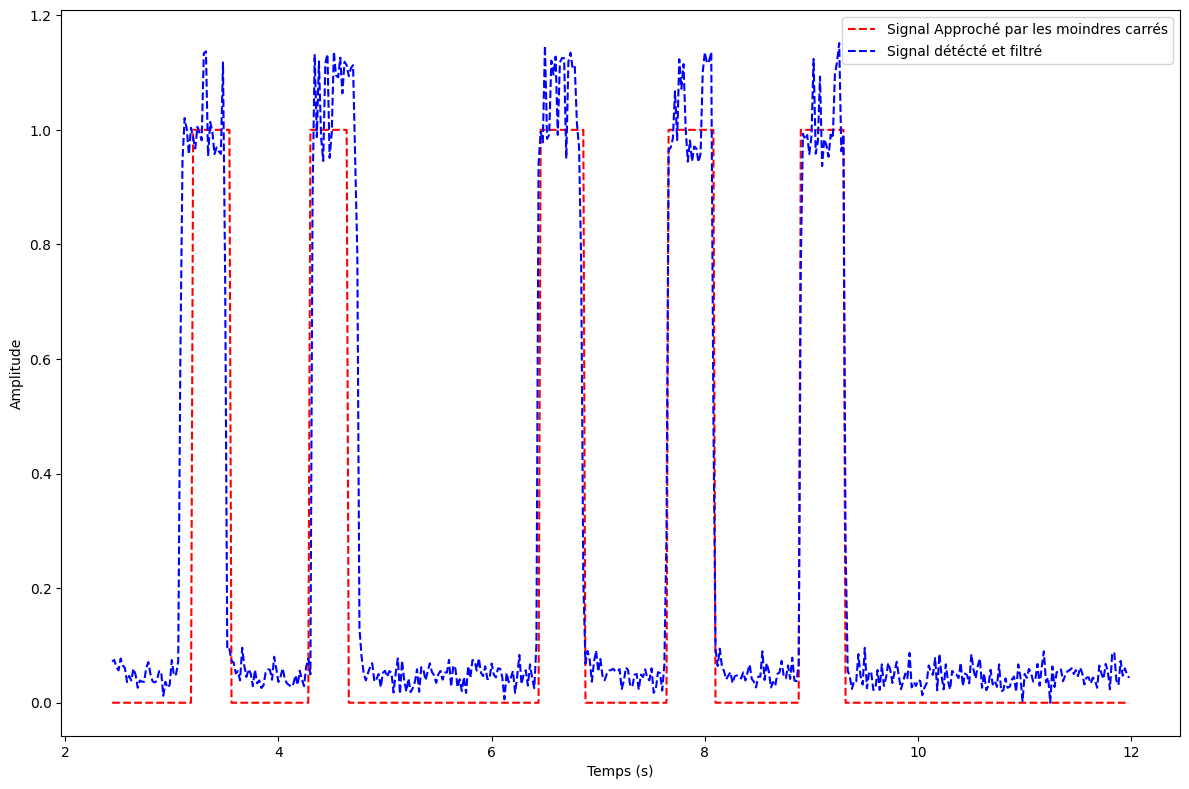

In [16]:
# Tracé des résultats
plt.figure(figsize=(12, 8))

#plt.plot(t, X_réel, label='Message réel',color="g")
plt.plot(t, X_approx, label='Signal Approché par les moindres carrés',color="r", linestyle='--')
plt.plot(t, x_green, label='Signal détécté et filtré',color="b", linestyle='--')
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")
plt.legend()

plt.tight_layout()
plt.savefig(f"{name}_plot_decoded.pdf")
plt.show()